# Algebraic Topological Data Analysis on rs-fMRI data to investigate free energy dynamics
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Introduction**
In this notebook, we compute the Euler characteristic and Betti numbers from simplicial complexes representing functional neural networks. The networks are constructed using rs-fMRI (resting-state functional magnetic resonance imaging) data. After computing these TDA metrics, we attempt to calculate the free energy of these networks.

## Importing data

**Import libraries**

In [1]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings
warnings.filterwarnings('ignore') 

**Import data**

Generate an average connectivity matrix from the whole human connectome dataset.

In [2]:
# Importing all matrices to generate averaged data with Numpy or Pandas
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]
matricesP = [pd.read_csv(file, header = None, delim_whitespace=True) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Averaging matrices with Numpy
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix

matrix = MatAv/len(matrices)

# Averaging matrices with Pandas
Pdmatrix = pd.concat(matricesP).groupby(level=0).mean()

Obtain region names and subnetwork information

In [3]:
# Obtaining name of areas according to matching file
lineList = [line.rstrip('\n') for line in open('./1000_Functional_Connectomes/Region Names/Baltimore_5560_region_names_abbrev_file.txt')]

# Obtaining a random list of numbers to simulate subnetworks -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
sublist = [line.rstrip('\n') for line in open('./subnet_ordernames.txt')]

# Obtaining a random list of colors that will match the random subnetwork classification for further graphs -- THESE COLORNAMES DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colorlist = [line.rstrip('\n') for line in open('./subnet_order_colors.txt')]

# Obtaining a random list of colors (in numbers) that will match the random subnetwork classification for further graphs -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colornumbs = np.genfromtxt('./subnet_colors_number.txt')

Plot heatmap of the correlation matrix.

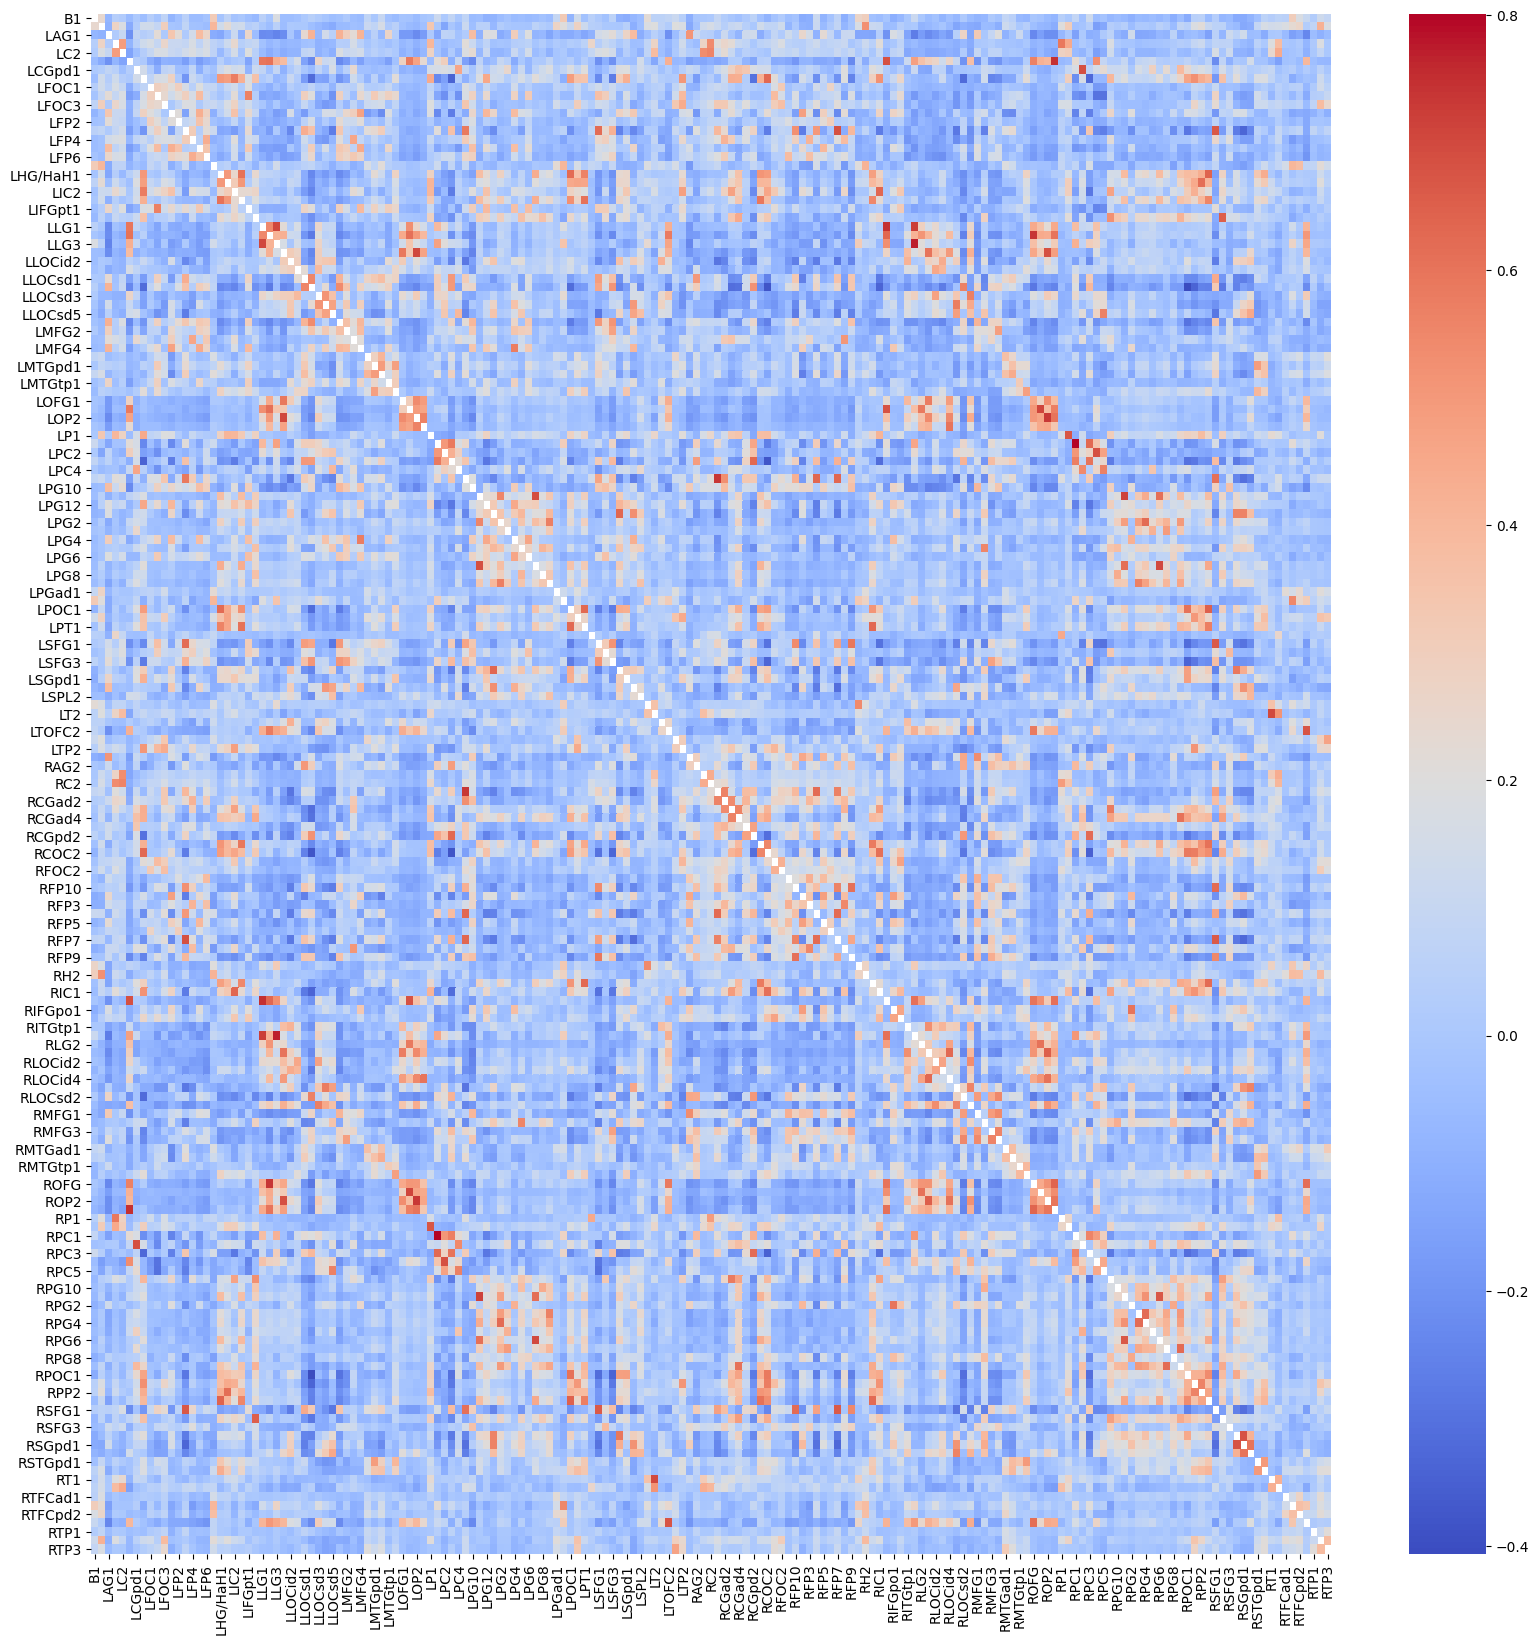

In [6]:
# Creating a DataFrame which will have the rows and column names according to the brain areas
matrixdiagNaN = matrix.copy()
np.fill_diagonal(matrixdiagNaN,np.nan)
Pdmatrix = pd.DataFrame(matrixdiagNaN)
Pdmatrix.columns = lineList
Pdmatrix.index = lineList
Pdmatrix = Pdmatrix.sort_index(0).sort_index(1)

# This mask variable gives you the possibility to plot only half of the correlation matrix. 
mask = np.zeros_like(Pdmatrix.values, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

plt.figure(figsize = (20, 20))
_ = sns.heatmap(Pdmatrix, cmap='coolwarm', cbar=True, square=False, mask=None) # To apply the mask, change to mask=mask

## Compute graph metrics

First, absolutise the weighted matrix, so potential biological information from negative correlation is maintained.

In [7]:
# Absolutise for further user
matrix = abs(matrix)
matrixdiagNaN = abs(matrixdiagNaN)

Create a graph from the matrix and remove any self-loops

In [12]:
# Creating a graph
G = nx.from_numpy_matrix(matrix)

# Removing self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

Now, compute the **density** of the graph. A graph's density is the ratio between the number of edges and the total number of possible edges. 

In [13]:
#print(nx.density.__doc__)

# Create graphs for comparison
matrix2 = matrix.copy()
matrix3 = matrix.copy()

# Create sparser graphs
matrix2[matrix2<=0.50] = 0
matrix3[matrix3<=0.75] = 0

st50G = nx.from_numpy_matrix(matrix2)
st25G = nx.from_numpy_matrix(matrix3)

st50G.remove_edges_from(list(nx.selfloop_edges(st50G)))
st25G.remove_edges_from(list(nx.selfloop_edges(st25G)))

# Compute densities
alltoall = nx.density(G)
st50 = nx.density(st50G)
st25 = nx.density(st25G)

names = ['All-To-All', '> 0.5', '> 0.75']
values = [alltoall, st50, st25]

dict(zip(names, values))

{'All-To-All': 1.0,
 '> 0.5': 0.013161273754494093,
 '> 0.75': 0.00012840267077555214}

Now compute the **nodal degree** or strength, which is used to identify the importance of a node in the graph. In undirected weighted networks the node strength can be computed as the sum of the connectivity weights of the edges attached to each node.

In [14]:
# Computation of nodal degree/strength
#print(nx.degree.__doc__)

strength = G.degree(weight='weight')
strengths = {node: val for (node, val) in strength}
nx.set_node_attributes(G, dict(strength), 'strength') # Add as nodal attribute

# Normalized node strength values 1/N-1
normstrenghts = {node: val * 1/(len(G.nodes)-1) for (node, val) in strength}
nx.set_node_attributes(G, normstrenghts, 'strengthnorm') # Add as nodal attribute

# Computing the mean degree of the network
normstrengthlist = np.array([val * 1/(len(G.nodes)-1) for (node, val) in strength])
mean_degree = np.sum(normstrengthlist)/len(G.nodes)
print(mean_degree)

0.11425288701460302
